In [211]:
import numpy as np
from random import choices

def simulate_data_sequence(t_relax, t_excite, polling_rate, runtime):
    # Calculate the number of data points to generate
    num_points = int(runtime * polling_rate)

    lambda_e = np.log(2)/t_excite
    lambda_r = np.log(2)/t_relax
    
    
    # Calculate the probabilities of transition between states
    p_relax_to_excite = 1 - np.exp(-lambda_r / (polling_rate))
    p_excite_to_relax = 1 - np.exp(-lambda_e / (polling_rate))
    
    # Generate the data sequence
    data_sequence = np.zeros(num_points, dtype=int)
    state = 0
    for i in range(num_points):
        rand_num = np.random.rand()
        if state == 0:
            if rand_num < p_relax_to_excite:
                state = 1
        else:
            if rand_num < p_excite_to_relax:
                state = 0
        data_sequence[i] = state
    
    return data_sequence


In [256]:
import numpy as np
def simulate_data_sequence(t_relax, t_excite, polling_rate, runtime, n):
    # Calculate the number of data points to generate
    num_points = int(runtime * polling_rate)

    lambda_e = np.log(2)/t_excite
    lambda_r = np.log(2)/t_relax
    
    
    # Calculate the probabilities of transition between states
    p_relax_to_excite = 1 - np.exp(-lambda_r / (polling_rate))
    p_excite_to_relax = 1 - np.exp(-lambda_e / (polling_rate))
    sum = p_relax_to_excite+p_excite_to_relax
    population = [0,1]
    weights = [p_relax_to_excite/sum, p_excite_to_relax/sum]
    samples = np.array(choices(population, weights, k=n))
    # Generate the data sequence
    data_sequence = np.zeros([n, num_points+1], dtype=int)
    data_sequence[:, 0] = samples
    for i in range(num_points - 1):
        rand_num = np.random.rand(n)
        if (data_sequence[:, i] == 0).sum()>0:
            data_sequence[:, i+1][data_sequence[:, i] == 0] = rand_num[data_sequence[:, i] == 0] < p_relax_to_excite
        if (data_sequence[:, i] == 1).sum()>0:
            data_sequence[:, i+1][data_sequence[:, i] == 1] = rand_num[data_sequence[:, i] == 1] > p_excite_to_relax
    return data_sequence[:, 1:]


In [258]:
f = 1
sequence = simulate_data_sequence(t_relax=10, t_excite=1, polling_rate=f, runtime=100000, n=100)

In [259]:
sequence_0 = sequence[0]

In [262]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def make_plot(sequence):
    # Find the indices where the sequence changes from zero to one and from one to zero
    idx_rise = np.where(np.diff(sequence) == 1)[0]
    idx_fall = np.where(np.diff(sequence) == -1)[0]

    # Calculate the time difference between consecutive indices for each state
    rise_times = np.diff(idx_rise) / f
    fall_times = np.diff(idx_fall) / f

    if idx_rise[0] < idx_fall[0]:
        if len(idx_rise) > len(idx_fall):
            relaxed_states = idx_rise[1:] - idx_fall
        else:
            relaxed_states = idx_rise[1:] - idx_fall[:-1]
    else:
        if len(idx_rise) < len(idx_fall):
            relaxed_states = idx_rise - idx_fall[:-1]
        else:
            relaxed_states = idx_rise - idx_fall

    if idx_rise[0] < idx_fall[0]:
        if len(idx_rise) > len(idx_fall):
            excited_states = idx_fall - idx_rise[:-1]
        else:
            excited_states = idx_fall - idx_rise
    else:
        if len(idx_rise) < len(idx_fall):
            excited_states = idx_fall[1:] - idx_rise
        else:
            excited_states = idx_fall[1:] - idx_rise[:-1]

    relaxed_state_times = relaxed_states / f
    excited_state_times = excited_states / f
    # Calculate the histogram of the lifetime of the relaxed and excited states
    bins_relaxed = np.arange(1/f, np.max(relaxed_state_times)+2/f, 1/f)
    bins_excited = np.arange(1/f, np.max(excited_state_times)+2/f, 1/f)
    hist_relaxed, _ = np.histogram(relaxed_state_times, bins=bins_relaxed)
    hist_excited, _ = np.histogram(excited_state_times, bins=bins_excited)

    # Fit an exponential curve to the histogram
    def exponential(x, a, b):
        return a * np.exp(-b * x)

    popt_relaxed, _ = curve_fit(exponential, bins_relaxed[:-1], hist_relaxed)
    popt_excited, _ = curve_fit(exponential, bins_excited[:-1], hist_excited)
    r_t = popt_relaxed[1]
    print(f'relaxed: {np.log(2)/r_t}')
    r_e = popt_excited[1]
    print(f'relaxed: {np.log(2)/r_e}')

    # Plot the histograms and exponential curves
    plt.subplot(1, 2, 1)
    plt.hist(relaxed_state_times, bins=bins_relaxed, alpha=0.5, label='Relaxed state')
    plt.plot(bins_relaxed[:-1], exponential(bins_relaxed[:-1], *popt_relaxed), 'r--')
    plt.xlabel('Lifetime')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(excited_state_times, bins=bins_excited, alpha=0.5, label='Excited state')
    plt.plot(bins_excited[:-1], exponential(bins_excited[:-1], *popt_excited), 'r--')
    plt.xlabel('Lifetime')
    plt.ylabel('Frequency')
    plt.legend()

    plt.show()


/tmp/ipykernel_5832/1198514530.py:46: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
/tmp/ipykernel_5832/1198514530.py:46: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x)


relaxed: 9.817850922765142
relaxed: 1.0094770188100386


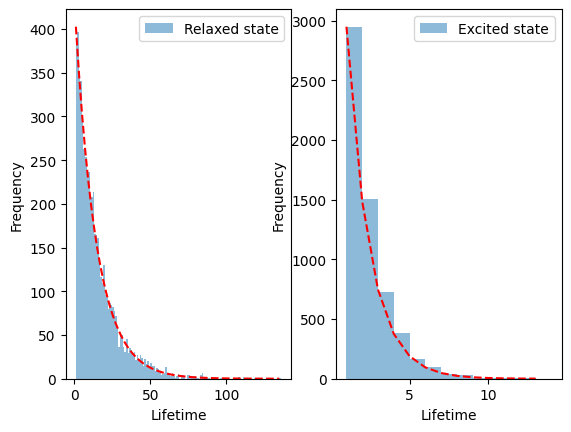

In [266]:
sequence_1 = sequence[2]
make_plot(sequence=sequence_1)